In [1]:
#This is the works for Udacity Self-driving-car-nd Term1 Project 3.
%matplotlib inline
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [2]:
# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [3]:
#Refer from : https://github.com/kuza55/keras-extras/blob/master/utils/multi_gpu.py
#Multi gpu support
from keras.layers import merge, concatenate
from keras.layers.core import Lambda
from keras.models import Model

import tensorflow as tf

def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            #merged.append(merge(outputs, mode='concat', concat_axis=0))
            merged.append(concatenate(outputs, axis=0))
            
        return Model(inputs=model.inputs, outputs=merged)

Using TensorFlow backend.


### Dataset

In [22]:
Folder_path = "./dataset/behavioral-cloning/train_data/"
Img_path = Folder_path + "IMG/"
df = pd.read_csv(Folder_path + "driving_log.csv", names=['center', 'left', 'right', 'steering', 'gas', 'brake', 'speed'])

df['left'] = df['left'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')
df['right'] = df['right'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')
df['center'] = df['center'].str.replace('/home/jaeoh2/Tools/linux_sim/','./dataset/behavioral-cloning/')

In [ ]:
#Load sample data
Folder_path = "./dataset/behavioral-cloning/sample_data/"
Img_path = Folder_path + "IMG/"
df = pd.read_csv(Folder_path + "driving_log.csv")

df['left'] = df['left'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['right'] = df['right'].str.replace(' IMG/','./dataset/behavioral-cloning/sample_data/IMG/')
df['center'] = df['center'].str.replace('IMG/','./dataset/behavioral-cloning/sample_data/IMG/')

In [23]:
df

,center,left,right,steering,gas,brake,speed
0,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.182353,1,0,30.06925
1,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.205882,1,0,30.18475
2,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.223529,1,0,30.18512
3,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.223529,1,0,30.18708
4,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.223529,1,0,30.18811
5,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.117647,1,0,30.19190
6,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.017647,1,0,30.18985
7,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.017647,1,0,30.19038
8,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.017647,1,0,30.19047
9,./dataset/behavioral-cloning/train_data/IMG/ce...,./dataset/behavioral-cloning/train_data/IMG/le...,./dataset/behavioral-cloning/train_data/IMG/ri...,-0.017647,1,0,30.19038


In [24]:
#data balancing refer from https://navoshta.com/end-to-end-deep-learning/
balanced = pd.DataFrame()
bins = 1000
bin_n = 200

start = 0
for end in np.linspace(0, 1, num=bins):
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n > 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv(Folder_path + 'driving_log_balanced.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fafda4950>]], dtype=object)

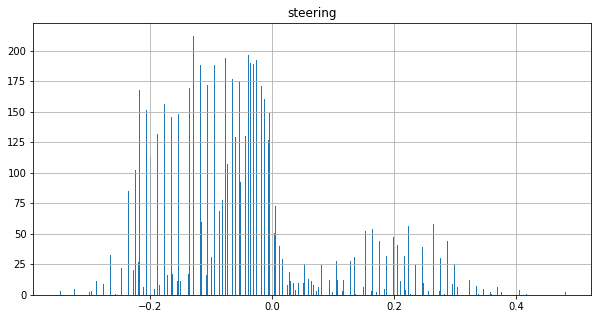

In [25]:
balanced.hist(column=['steering'], bins=1000, figsize=(10,5))

In [27]:
num_examples = len(df)
num_balanced = len(balanced)
print("Number of examplese : {}\nNumber of balanced : {}".format(num_examples, num_balanced))

Number of examplese : 50243
Number of balanced : 11876


### Data Augmentation

In [28]:
import random
import os, sys
import csv
from skimage.transform import rotate, warp, ProjectiveTransform, AffineTransform
import cv2

In [29]:
def random_translate(X, steer, intensity=1):
    delta = 15.* intensity
    rand_delta = random.uniform(-delta, delta)
    translate_matrix = AffineTransform(translation=(0, rand_delta))
    X = warp(X,translate_matrix)
    steer = steer
    return X, steer

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8fae4a4610>,
 (-0.5, 319.5, 159.5, -0.5))

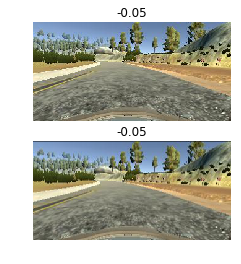

In [30]:
#test
ran_idx = random.randint(0, num_examples)
test_img = mpimg.imread(df.center[ran_idx])
test_str = float(df.steering[ran_idx])
test_rt_img, test_rt_str = random_translate(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.title(round(test_str,2)), plt.axis('off')
plt.subplot(2,1,2), plt.imshow(test_rt_img), plt.title(round(test_rt_str,2)), plt.axis('off')

In [31]:
def image_flip(X, steer):
    img_fliped = np.fliplr(X)
    str_fliped = -steer
    return img_fliped, str_fliped

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8fad266510>,
 (-0.5, 319.5, 159.5, -0.5),
 <matplotlib.text.Text at 0x7f8fad17da10>)

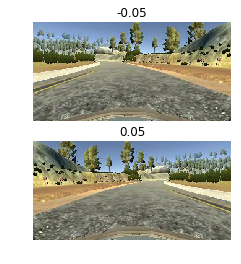

In [32]:
#test
test_fl_img, test_fl_str = image_flip(test_img, test_str)
plt.subplot(2,1,1), plt.imshow(test_img), plt.axis('off'), plt.title(round(test_str,2))
plt.subplot(2,1,2), plt.imshow(test_fl_img), plt.axis('off'), plt.title(round(test_fl_str,2))

In [33]:
def random_brightness(image):
    #Convert 2 HSV colorspace from RGB colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #Generate new random brightness
    rand = random.uniform(0.3,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    #Convert back to RGB colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img 

In [34]:
import math
import cv2
def preprocess_image(X):
    X = cv2.resize(X[60:140,:], (64,64), interpolation=cv2.INTER_AREA)
    return X

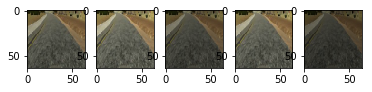

In [35]:
#test
for i in range(5):
    test_resize_img = random_brightness(test_img)
    test_resize_img = preprocess_image(test_resize_img)
    plt.subplot(1,5,i+1), plt.imshow(test_resize_img)

In [36]:
center = df.center.tolist()
left = df.left.tolist()
right = df.right.tolist()
steering = df.steering.tolist()
leftsteering = (df.steering + 0.25).tolist()
rightsteering = (df.steering - 0.25).tolist()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train = center + left + right
y_train = steering + leftsteering + rightsteering

X_train, y_train = shuffle(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(center, steering, test_size=0.2)

In [38]:
def transform_images(X, y):
    X = random_brightness(X)
    #X,y = random_translate(X, y, intensity=1)
    if np.random.randint(2) == 0:
        X, y = image_flip(X, y)
    X = preprocess_image(X)
    return X,y

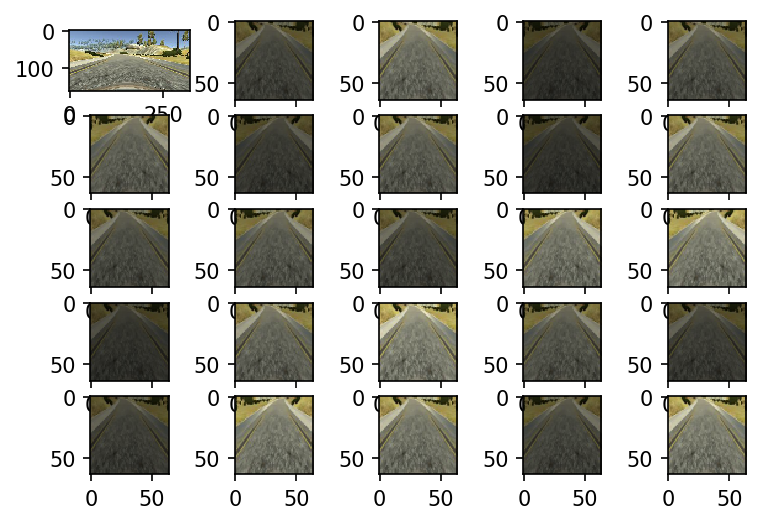

In [39]:
#test
plt.figure(dpi=150)
for i in range(5):
    test_img = mpimg.imread(X_train[0])
    plt.subplot(5,5,i+1),plt.imshow(transform_images(test_img, y_train[0])[0])
    plt.subplot(5,5,i+6),plt.imshow(transform_images(test_img, y_train[0])[0])
    plt.subplot(5,5,i+11),plt.imshow(transform_images(test_img, y_train[0])[0])
    plt.subplot(5,5,i+16),plt.imshow(transform_images(test_img, y_train[0])[0])
    plt.subplot(5,5,i+21),plt.imshow(transform_images(test_img, y_train[0])[0])
    plt.subplot(5,5,1),plt.imshow(test_img)

In [40]:
def get_transform_images(Xs, ys, n_each=10):
        
    X_arr = []
    y_arr = []
    
    
    #Parallel(n_jobs=nprocs)(delayed(preprocess_image)(imfile) for imfile in Xs)
    
    for i, (x, y) in enumerate(zip(Xs,ys)):
        for _ in range(n_each):
            img = mpimg.imread(x)
            img_trf, label_trf = transform_images(img, y)
            X_arr.append(img_trf)
            y_arr.append(label_trf)
        
        print_progress(i+1, len(Xs))
        
    X_arr = np.asarray(X_arr, dtype=np.float32)
    y_arr = np.asarray(y_arr, dtype=np.float32)
    
    return X_arr, y_arr    

In [ ]:
X_trf, y_trf = get_transform_images(X_train, y_train)

 |██████████████████████████--------------------------------------------------------------------------| 26%

In [ ]:
X_trf_val, y_trf_val = get_transform_images(X_valid, y_valid)

In [ ]:
X_trf.shape, y_trf.shape, X_trf_val.shape, y_trf_val.shape

In [ ]:
print("Saving preprocessed Train images")
np.save(Folder_path + "TrainX.npy", X_trf)
np.save(Folder_path + "Trainy.npy", y_trf)
np.save(Folder_path + "ValidX.npy", X_trf_val)
np.save(Folder_path + "Validy.npy", y_trf_val)
print("Saving Done")

### Model

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Cropping2D
from keras.optimizers import adam

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers import Lambda

In [ ]:
#Model Configurations
img_height = 64
img_width = 64
img_ch = 3

f_size = 3
learning_rate = 1e-2
activation = 'elu'

In [ ]:
def build_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255. -0.5, input_shape=(img_height, img_width, img_ch)))
    model.add(Conv2D(16,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(32,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3), activation=activation, padding='valid'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(500, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(20, activation=activation))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    
    model.summary()
    #model = make_parallel(model,2)
    model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])
    
    return model


In [ ]:
model = build_model()
model_checkpoint = ModelCheckpoint('model.h5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

In [ ]:
import numpy as np
Folder_path = "./dataset/behavioral-cloning/sample_data/"

X_train = np.load(Folder_path + "TrainX.npy")
y_train = np.load(Folder_path + "Trainy.npy")
X_valid = np.load(Folder_path + "ValidX.npy")
y_valid = np.load(Folder_path + "Validy.npy")

In [ ]:
model.fit(X_train, y_train, batch_size=1024, epochs=100, verbose=1, shuffle=True,
          validation_data=(X_valid, y_valid),
         callbacks=[model_checkpoint, model_earlystopping])

model.fit_generator(train_generator,
                    steps_per_epoch=9000,#len(X_train),
                    validation_data=validation_generator,
                    validation_steps=2000,#len(X_valid),
                    callbacks=[model_checkpoint],
                    epochs=3)

In [ ]:
with open('model.json', 'w') as file:
        file.write(model.to_json())

### Results